## Neural Style Transfer

Neural style transfer takes two inputs: a content image (the image whose structure we want to preserve) and a style image (the image from which we extract artistic style). The output is a new image that blends the content of the first with the style of the second.

In [84]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import torchvision

DEVICE = 'cuda'

### Content Image

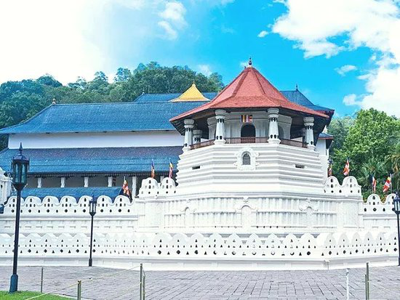

In [85]:
content_image = Image.open("content.jpg")
resize_content_image = content_image.resize((400, 300))
resize_content_image.show()

### style image

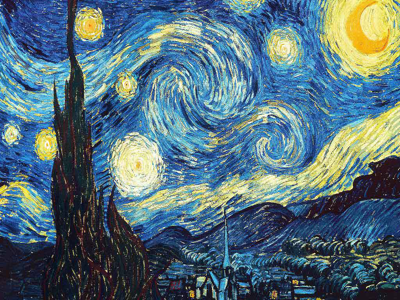

In [86]:
style_image = Image.open("style.jpg")
resize_style_image = style_image.resize((400, 300))
resize_style_image.show()

We need to process both images before passing onto a Neural Net

In [87]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to('cpu')
    img = torch.clamp(img.permute(1, 2, 0) * std + mean, 0, 1)
    return transforms.ToPILImage()(img.permute(2, 0, 1))

In [88]:
backbone = torchvision.models.inception_v3(pretrained=True).to(DEVICE).eval()

/home/ubuntu/miniconda3/envs/senu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/senu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:
style_layers, content_layers = [0, 5, 10, 15, 20], [19]

In [90]:
# Define the layers we want to use for style transfer
layers = []
for layer in backbone.children():
    if isinstance(layer, (nn.Conv2d, nn.MaxPool2d, nn.AvgPool2d)):
        layers.append(layer)
    if isinstance(layer, nn.Sequential):
        for l in layer.children():
            if isinstance(l, (nn.Conv2d, nn.MaxPool2d, nn.AvgPool2d)):
                layers.append(l)
    if len(layers) > max(max(style_layers), max(content_layers)):
        break

# Create sequential network using selected layers
net = nn.Sequential(*layers[:max(max(style_layers), max(content_layers)) + 1])

In [91]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [92]:
def get_content(image_shape, device):
    content_X = preprocess(resize_content_image, image_shape).to(device)
    content_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, content_Y

def get_style(image_shape, device):
    style_X = preprocess(resize_style_image, image_shape).to(device)
    _, style_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, style_Y

### for the content loss we usually use the MSE as we need to keep the content similat to the original image 

In [104]:
def content_loss(Y_hat, y):
    return torch.square(Y_hat, y).mean()

In [105]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [106]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [107]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
            torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [108]:
content_weight, style_weight, tv_weight = 1, 1e5, 10
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [109]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))
    def forward(self):
        return self.weight

In [110]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [111]:
import d2l

In [112]:
import matplotlib.pyplot as plt

def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    
    # Create figure for visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    losses = {'content': [], 'style': [], 'tv': []}
    
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            # Update losses
            losses['content'].append(float(sum(contents_l)))
            losses['style'].append(float(sum(styles_l)))
            losses['tv'].append(float(tv_l))
            
            # Plot losses
            ax1.clear()
            for loss_type, values in losses.items():
                ax1.plot(range(10, epoch + 2, 10), values, label=loss_type)
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.legend()
            ax1.set_xlim([10, num_epochs])
            
            # Show current image
            ax2.clear()
            ax2.imshow(postprocess(X))
            ax2.axis('off')
            
            plt.pause(0.1)
            
    plt.close()
    return X


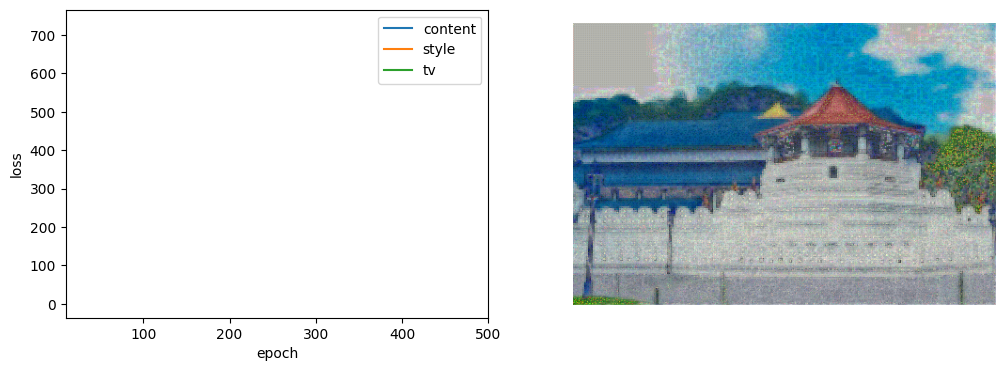

In [113]:
device, image_shape = 'cuda', (300, 450) # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_content(image_shape, device)
_, styles_Y = get_style(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)